In [5]:
import numpy as np
import missingno as msno
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import is_string_dtype, is_numeric_dtype  
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import cross_val_score


import utils as u

In [6]:
%matplotlib inline 
rcParams['figure.figsize'] = 5,4 

#### Prediccion del valor de automoviles
Se leen los datso iniciales para conocer el numero de registros y variables

In [15]:
df_inicial = pd.read_csv("datos_para_trabajo.csv")
print("Numero de registros y variables: " , df_inicial.shape)
df_inicial.head(3)

Numero de registros y variables:  (205, 24)


,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,lnprice
0,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.090345,mpfi,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.343992
1,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.090345,mpfi,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.741219
2,alfa-romero,gas,std,two,hatchback,rwd,front,-0.708596,-0.231513,-0.190566,...,0.646977,mpfi,-2.399480,0.675523,-0.288349,1.265619,-0.270357,-0.953012,-0.691627,0.741219


Datos faltantes: en principio no existen ya que en el encabezado del problema se indico que el conjunto de datos tiene una limpieza previa

Datos faltantes
make                 0
fuel_type            0
aspiration           0
num_of_doors         0
body_style           0
drive_wheels         0
engine_location      0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_type          0
num_of_cylinders     0
engine_size          0
fuel_system          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
lnprice              0
dtype: int64


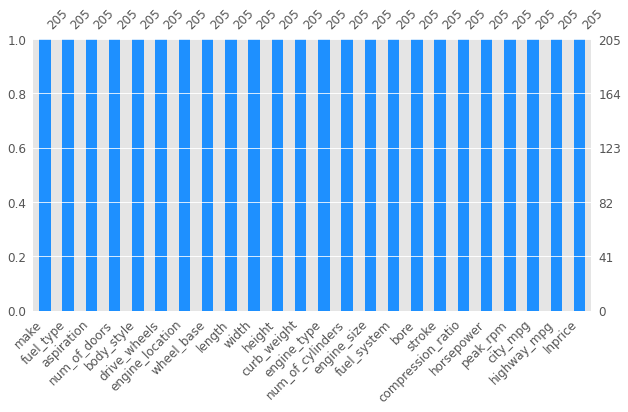

In [8]:
print("Datos faltantes")
print(df_inicial.isnull().sum())
plt.style.use('ggplot')
msno.bar(df_inicial, figsize=(10,5), color="dodgerblue", fontsize=12)

Se imprime el tipo de datos de cada variable

In [9]:
df_inicial.dtypes

make                  object
fuel_type             object
aspiration            object
num_of_doors          object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight          float64
engine_type           object
num_of_cylinders      object
engine_size          float64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg             float64
highway_mpg          float64
lnprice              float64
dtype: object

 Separamos entre las variable numericas y categoricas

In [18]:
num_list = []
cat_list = []

for column in df_inicial:
    if is_numeric_dtype(df_inicial[column]):
        num_list.append(column)
    elif is_string_dtype(df_inicial[column]):
        cat_list.append(column)
print('Categoricas: ', cat_list)
print('Numericas: ', num_list)

Categoricas:  ['make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style', 'drive_wheels', 'engine_location', 'engine_type', 'num_of_cylinders', 'fuel_system']
Numericas:  ['wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'lnprice', 'fuel_mpg']


A continuacion se analiza las correlaciones existentes entre las variables

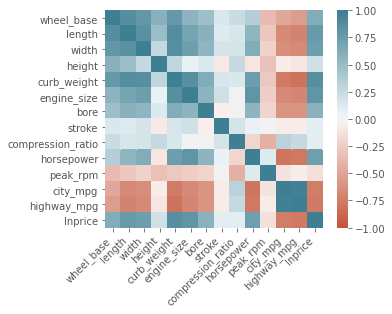

In [11]:
corr = df_inicial[num_list].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Se observa que las variables city_mpg y highway_mpg estan muy correlacionadas entre si, se puede seleccionar una y continuar con el analisis o en este caso se va a calcular una nueva variable.
Las variables peak_rpm, compression_ratio, stroke y height son las que menos se correlacionan con la variable objetivo, podrian quitarse del conjunto de datos.

### Feature engineering
Se crea una nueva variable que pondere con el mismo porcentaje el consumo de combustible en ciudad y carretera

In [16]:
df_inicial['fuel_mpg'] = (0.50 * df_inicial['city_mpg']) + (0.50 * df_inicial['highway_mpg'])

Quitamos las variables menos correlacionadas con la variable objetivo stroke, compression_ratio


Se retira tambien la variable highway-mpg ya que esta muy correlacionada con city-mpg

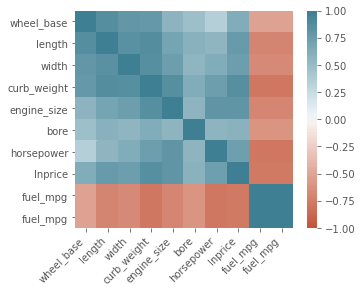

In [19]:

num_list.append('fuel_mpg')
num_list.remove('stroke')
num_list.remove('compression_ratio')
num_list.remove('height')
num_list.remove('peak_rpm')
num_list.remove('city_mpg')
num_list.remove('highway_mpg')

corr = df_inicial[num_list].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [20]:
corr

,wheel_base,length,width,curb_weight,engine_size,bore,horsepower,lnprice,fuel_mpg,fuel_mpg
wheel_base,1.000000,0.874587,0.795144,0.776386,0.576057,0.471522,0.354480,0.631025,-0.510922,-0.510922
length,0.874587,1.000000,0.841118,0.877728,0.694487,0.591369,0.548479,0.769842,-0.692767,-0.692767
width,0.795144,0.841118,1.000000,0.867032,0.742741,0.551066,0.636906,0.746479,-0.664742,-0.664742
curb_weight,0.776386,0.877728,0.867032,1.000000,0.863217,0.635681,0.748539,0.859842,-0.783071,-0.783071
engine_size,0.576057,0.694487,0.742741,0.863217,1.000000,0.563226,0.811824,0.813712,-0.681033,-0.681033
bore,0.471522,0.591369,0.551066,0.635681,0.563226,1.000000,0.565843,0.585912,-0.608919,-0.608919
horsepower,0.354480,0.548479,0.636906,0.748539,0.811824,0.565843,1.000000,0.733589,-0.788147,-0.788147
lnprice,0.631025,0.769842,0.746479,0.859842,0.813712,0.585912,0.733589,1.000000,-0.761520,-0.761520
fuel_mpg,-0.510922,-0.692767,-0.664742,-0.783071,-0.681033,-0.608919,-0.788147,-0.761520,1.000000,1.000000
fuel_mpg,-0.510922,-0.692767,-0.664742,-0.783071,-0.681033,-0.608919,-0.788147,-0.761520,1.000000,1.000000


Se analizan las variables categoricas y si existe una correlacion con la variable objetivo

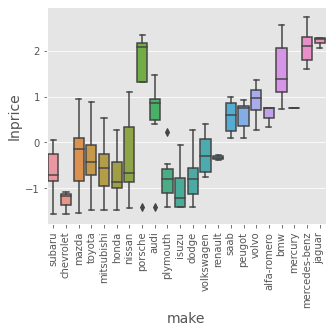

In [21]:
g = sns.boxplot(x='make',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('make',size=14);

In [22]:
Counter(df_inicial.make)

Counter({'alfa-romero': 3,
         'audi': 7,
         'bmw': 8,
         'chevrolet': 3,
         'dodge': 9,
         'honda': 13,
         'isuzu': 4,
         'jaguar': 3,
         'mazda': 17,
         'mercedes-benz': 8,
         'mercury': 1,
         'mitsubishi': 13,
         'nissan': 18,
         'peugot': 11,
         'plymouth': 7,
         'porsche': 5,
         'renault': 2,
         'saab': 6,
         'subaru': 12,
         'toyota': 32,
         'volkswagen': 12,
         'volvo': 11})

Dado que hay un conteo muy pequeño de autos en una marca, se pueden agrupar, ademas se observa en la grafica que  un grupo de autos tienen mayor precio. Se agrupan en 3 categorias

In [23]:
temp = df_inicial.copy()
table = df_inicial.groupby(['make'])['lnprice'].mean()
temp = temp.merge(table.reset_index(), how='left',on='make')
bins = [-2,-0.5,1,3]
cars_bin=['economico','medio','costoso']
df_inicial['price_range'] = pd.cut(temp['lnprice_y'],bins,right=False,labels=cars_bin)
df_inicial.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,lnprice,fuel_mpg,price_range
0,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.343992,-0.596306,medio
1,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.741219,-0.596306,medio
2,alfa-romero,gas,std,two,hatchback,rwd,front,-0.708596,-0.231513,-0.190566,...,-2.399480,0.675523,-0.288349,1.265619,-0.270357,-0.953012,-0.691627,0.741219,-0.822319,medio
3,audi,gas,std,four,sedan,fwd,front,0.173698,0.207256,0.136542,...,-0.532364,0.452216,-0.035973,-0.048061,0.777340,-0.186865,-0.109354,0.409512,-0.148109,medio
4,audi,gas,std,four,sedan,4wd,front,0.107110,0.207256,0.230001,...,-0.532364,0.452216,-0.540725,0.280359,0.777340,-1.106241,-1.273900,0.851826,-1.190071,medio


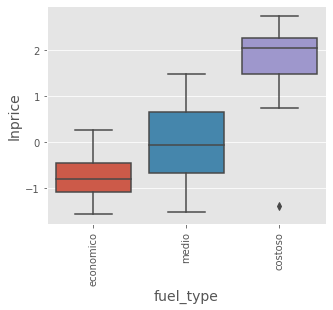

In [24]:
g = sns.boxplot(x='price_range',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('fuel_type',size=14);

Se grafican las demas variables, se pondra atencion en como varian las medias en cada categoria y si se pueden calcular nuevas variables

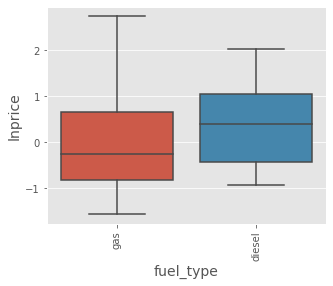

In [25]:
g = sns.boxplot(x='fuel_type',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('fuel_type',size=14);

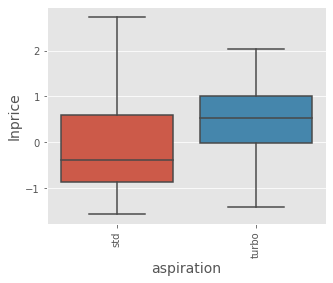

In [26]:
g = sns.boxplot(x='aspiration',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('aspiration',size=14);

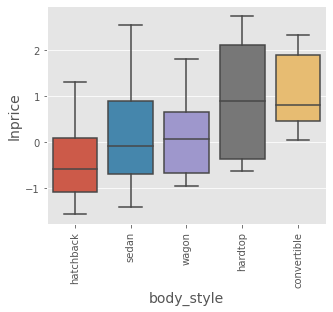

In [27]:
g = sns.boxplot(x='body_style',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('body_style',size=14);

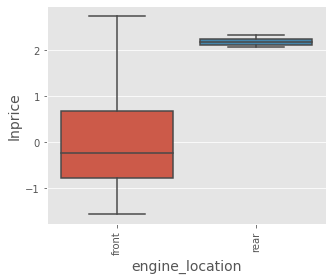

In [28]:
g = sns.boxplot(x='engine_location',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('engine_location',size=14);

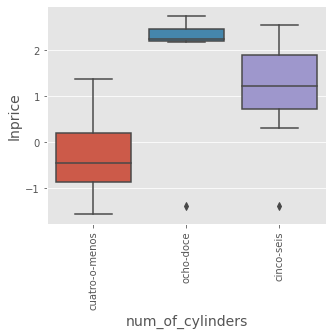

In [29]:
g = sns.boxplot(x='num_of_cylinders',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('num_of_cylinders',size=14);

In [ ]:
g = sns.boxplot(x='fuel_system',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('make',size=14);

Se crea un dataset con las variables con las que se continua al modelado

In [30]:
## Variables finales
df_inicial.drop(['city_mpg','highway_mpg','engine_type','drive_wheels','num_of_doors','stroke','compression_ratio','height','peak_rpm', 'make'], axis=1, inplace=True)

In [31]:
df_inicial.columns

Index(['fuel_type', 'aspiration', 'body_style', 'engine_location',
       'wheel_base', 'length', 'width', 'curb_weight', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'horsepower', 'lnprice',
       'fuel_mpg', 'price_range'],
      dtype='object')

In [32]:
df_modelo = df_inicial[['fuel_type', 'aspiration', 'body_style', 'engine_location',
       'wheel_base', 'length', 'width', 'curb_weight', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'horsepower',
       'fuel_mpg', 'price_range', 'lnprice']]
print("Numero de filas y variables final: " , df_modelo.shape)
df_modelo.head(5)

Numero de filas y variables final:  (205, 16)


,fuel_type,aspiration,body_style,engine_location,wheel_base,length,width,curb_weight,num_of_cylinders,engine_size,fuel_system,bore,horsepower,fuel_mpg,price_range,lnprice
0,gas,std,convertible,front,-1.690772,-0.426521,-0.844782,-0.014566,cuatro-o-menos,0.090345,mpfi,0.492718,0.179306,-0.596306,medio,0.343992
1,gas,std,convertible,front,-1.690772,-0.426521,-0.844782,-0.014566,cuatro-o-menos,0.090345,mpfi,0.492718,0.179306,-0.596306,medio,0.741219
2,gas,std,hatchback,front,-0.708596,-0.231513,-0.190566,0.514882,cinco-seis,0.646977,mpfi,-2.399480,1.265619,-0.822319,medio,0.741219
3,gas,std,sedan,front,0.173698,0.207256,0.136542,-0.420797,cuatro-o-menos,-0.440986,mpfi,-0.532364,-0.048061,-0.148109,medio,0.409512
4,gas,std,sedan,front,0.107110,0.207256,0.230001,0.516807,cinco-seis,0.242154,mpfi,-0.532364,0.280359,-1.190071,medio,0.851826


Se transforma las variables categoricas

In [33]:
lst_cat = ['fuel_type', 'aspiration', 'body_style', 'engine_location', 'num_of_cylinders', 'fuel_system','price_range']

for col in lst_cat:
    
    df_modelo[col] = df_modelo[col].astype('category')
    df_modelo[col] = df_modelo[col] .cat.codes

df_modelo.head(3)

,fuel_type,aspiration,body_style,engine_location,wheel_base,length,width,curb_weight,num_of_cylinders,engine_size,fuel_system,bore,horsepower,fuel_mpg,price_range,lnprice
0,1,0,0,0,-1.690772,-0.426521,-0.844782,-0.014566,1,0.090345,5,0.492718,0.179306,-0.596306,1,0.343992
1,1,0,0,0,-1.690772,-0.426521,-0.844782,-0.014566,1,0.090345,5,0.492718,0.179306,-0.596306,1,0.741219
2,1,0,2,0,-0.708596,-0.231513,-0.190566,0.514882,0,0.646977,5,-2.399480,1.265619,-0.822319,1,0.741219


#### Modelos

In [34]:
X = df_modelo.loc[:, df_modelo.columns != 'lnprice']
y = df_modelo['lnprice']

Se divide en conjunto de train y test (75 - 25)

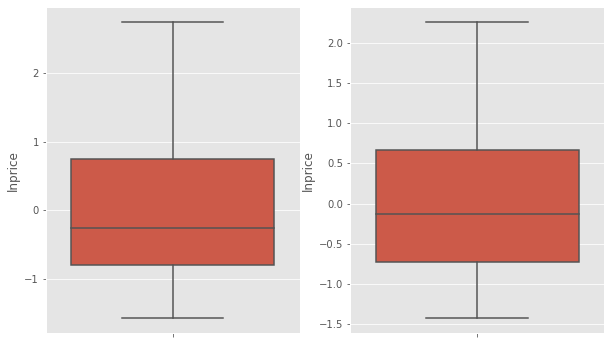

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 2402)

plt.subplots(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y = (y_train))

plt.subplot(1, 2, 2)
sns.boxplot(y = (y_test))

### Modelo inicial - linea base

In [36]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 2402)
# Entrenar el modelo
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=2402)

In [37]:
print ('-----------')
print ('RFR - linea base')
print ('-----------')
u.launch_model('RFR - linea base', rf, X_train, y_train, X_test, y_test);

-----------
RFR - linea base
-----------
MSE train 0.09354523250364706
MSE test 0.3211972915731162
R^2 train 0.9717422916348155
R^2 test 0.7858635191236774


En primera instancia se puede observar que este modelo inicial entrega una prediccion con overfitting.
Se va a realizar una mejora de este modelo tomando en consideracion dos metricas R^2 y el error cuadratico medio.

Mejorando el modelo

In [39]:
rf = RandomForestRegressor(random_state = 2402)
from pprint import pprint
print('Parametros a optimizar:\n')
pprint(rf.get_params())

Parametros a optimizar:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2402,
 'verbose': 0,
 'warm_start': False}


In [40]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Se usa una grilla random para encontrar los mejores parametros, se ussa cross validation con 3 folds

In [41]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [42]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [43]:
best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=400)

In [44]:
print ('-----------')
print ('RFR - best random')
print ('-----------')
u.launch_model('RFR - best random', best_random, X_train, y_train, X_test, y_test);

-----------
RFR - best random
-----------
MSE train 0.13569608445934356
MSE test 0.2934859954373316
R^2 train 0.955035080970423
R^2 test 0.8447203343862093


Se mejora la busqueda en la grilla usando los valores random encontrados

In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [400, 500, 600, 700]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [48]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  7.7min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [30, 40, 50, 60],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [400, 500, 600, 700]},
             verbose=2)

In [49]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 400}

In [50]:
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features=2, min_samples_split=4,
                      n_estimators=400)

In [51]:
print ('-----------')
print ('RFR - best grid')
print ('-----------')
u.launch_model('RFR - best grid', best_grid, X_train, y_train, X_test, y_test);

-----------
RFR - best grid
-----------
MSE train 0.1326572615313703
MSE test 0.290516892005361
R^2 train 0.9604331537062217
R^2 test 0.8414258520418905


El mejor modelo usando random forest es best grid. Se consideran dos metricas para esta seleccion.
MSE (Error cuadratico medio) mientras menor sea es mejor
y el R^2 (r-square) mientras mas cercano a uno es mejor. 

Para identificar el underfitting se considera el error entre el conjunto de entrenamiento y prueba, pensando en que el error en el conjunto de train debe ser menor que el de test.

Para identificar overfitting en cambio se verifica el valor de R^2, para entrenamiento debe ser mayor que para prueba. Este modelo tiene un R^2 para test del 84% y para entrenamiento 96%

SVR Model

In [52]:
from sklearn.svm import SVR

svr_lineal = SVR(kernel='linear')

In [53]:
svr_lineal.fit(X_train, y_train)

SVR(kernel='linear')

In [54]:
print ('-----------')
print ('SVR - base')
print ('-----------')
u.launch_model('SVR - base', svr_lineal, X_train, y_train, X_test, y_test);

-----------
SVR - base
-----------
MSE train 0.250489306360168
MSE test 0.2983473556415824
R^2 train 0.8047551273054001
R^2 test 0.8564123999086355


Usando SRV en cambio se llega a un R^2 del 85% para test contra 80% en entrenamiento, el modelo tiene overfitting (el R^2 es mejor en test que en train). Se usa una grilla para buscar mejores parametros para el modelo

In [55]:
from sklearn.model_selection import RepeatedKFold

model = SVR()
kernel = ["linear", "rbf", "sigmoid", "poly"]
tolerance = [1e-3, 1e-4, 1e-5, 1e-6]
C = [1, 1.5, 2, 2.5, 3]
grid = dict(kernel=kernel, tol=tolerance, C=C)

cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
gridSearch = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,
	cv=cvFold, scoring="neg_mean_squared_error")
searchResults = gridSearch.fit(X_train, y_train)

In [56]:
bestModel_SVR = searchResults.best_estimator_
bestModel_SVR.fit(X_train,y_train)

SVR(C=2)

In [57]:
print ('-----------')
print ('SVR - tuning')
print ('-----------')
u.launch_model('SVR - tuning', bestModel_SVR, X_train, y_train, X_test, y_test);

-----------
SVR - tuning
-----------
MSE train 0.18893817855568953
MSE test 0.29649235762949294
R^2 train 0.8903297315441798
R^2 test 0.8589527240569459


Se corrije el overfitting y mejora tambien el error sobre el conjunto de test

Se toman entonces los dos mejores modelos de cada algoritmo y se continua con el analisis de errores para seleccionar uno que ora a produccion

Seleccion del modelo y analisis de errores

In [60]:
results = []
print ('-----------')
print ('SVR - RBF')
print ('-----------')
results.append(u.launch_model('SVR - RBF', bestModel_SVR, X_train, y_train, X_test, y_test))
print ('-----------')
print ('RF - Best Model')
print ('-----------')
results.append(u.launch_model('RF - Best Model', best_grid, X_train, y_train, X_test, y_test))

-----------
SVR - RBF
-----------
MSE train 0.18893817855568953
MSE test 0.29649235762949294
R^2 train 0.8903297315441798
R^2 test 0.8589527240569459
-----------
RF - Best Model
-----------
MSE train 0.13269827096090456
MSE test 0.2908370814450394
R^2 train 0.9621464781899136
R^2 test 0.8452486808587104


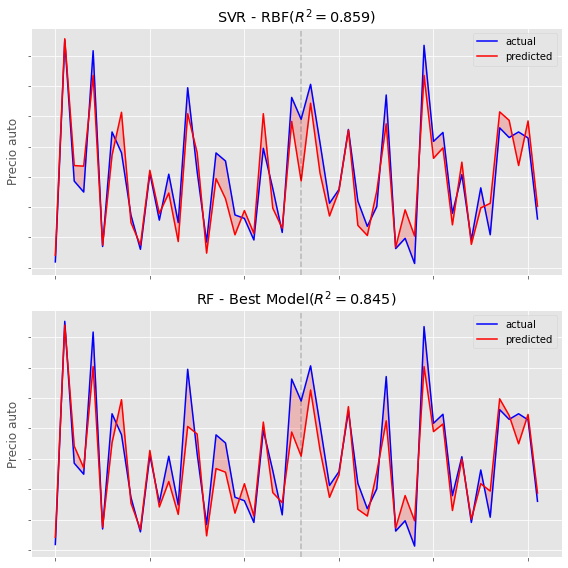

In [62]:
u.plot(results)

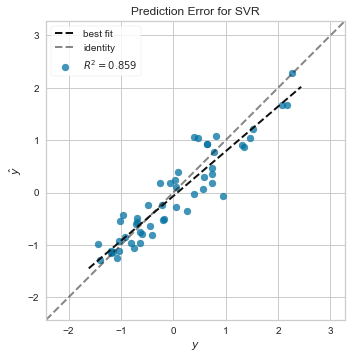

In [68]:
visualizer = PredictionError(bestModel_SVR)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
g = visualizer.poof()            

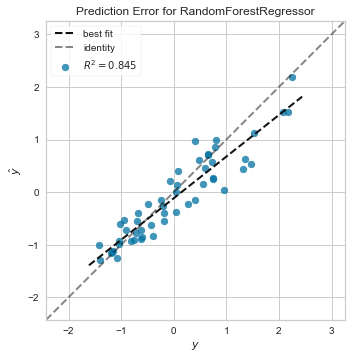

In [69]:
visualizer = PredictionError(best_grid)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
g = visualizer.poof()  

A continuacion se visualiza el error de prediccion usando los datos de test frente a los valores predichos por cada modelo de regresion, de esta manera se puede observar la varianza de cada modelo. Se observa que el modelo con SVR es mejor ya que los puntos se distribuyen de mejor manera sobre la linea de 45 grados.
Para valores mas altos de la variable objetivo, el modelo de random forest tiene sus predicciones menores a las reales. Lo que significa que usar este modelo traeria perdidas al negocio al predecir valores mas bajos que los reales.

En los precios bajos ambos modelos se comportan bastante parecido.

Vamos a analizar tambien como se distribuyen los residuos de las predicciones.
La parte determinista del modelo es la que se intenta captar mediante el modelo de regresión. Idealmente, los modelos deberían capturar con precisión la información predictiva. Básicamente, esto significa que si se captura toda la información predictiva, todo lo que queda (los residuos) deberían ser completamente aleatorios e impredecibles, es decir, estocástico. 

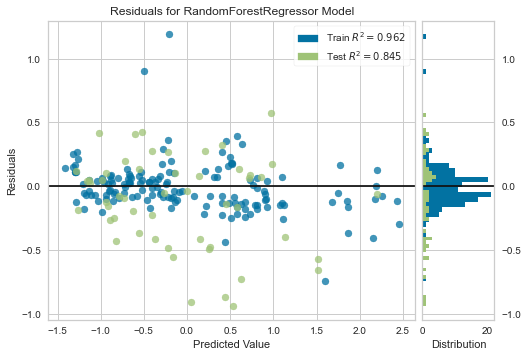

In [82]:
# Modelo Random Forest
visualizer = ResidualsPlot(best_grid)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()            

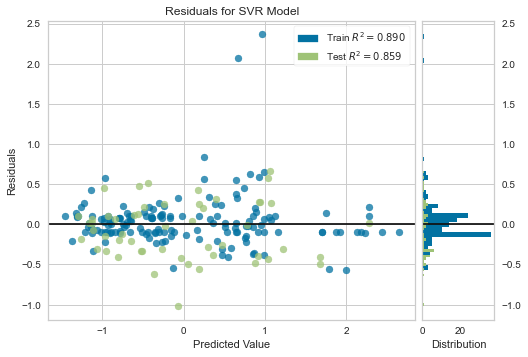

In [83]:
# Modelo SVR
visualizer = ResidualsPlot(bestModel_SVR)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()  

Se observan que los residuos se distribuyen de manera aleatoria alrededor del origen para ambos modelos, siendo menos dispersos para el modelo de SRV. 

#### Resultados

El modelo seleccionado para este conjunto de datos es el SVR. Con un MSE de 0.296 y R^2 0.86.
Se reviso que el modelo no tenga overfitting, ni underfitting, ademas se graficaron las predicciones y los residuos de ambos modelos.

A continuacion se presentan las variables en orden de importancia:
* Las variables mas importantes son: fuel_mpg, curb_weight y horse power
* Se observa que para valores menores de la variable fuel_mpg (variable calculada) el valor de la variable objetivo es mayor, estan correlacionados de manera negativa. Para la variable curb_weight ocurre lo contrario, esta correlacionado de manera positiva.


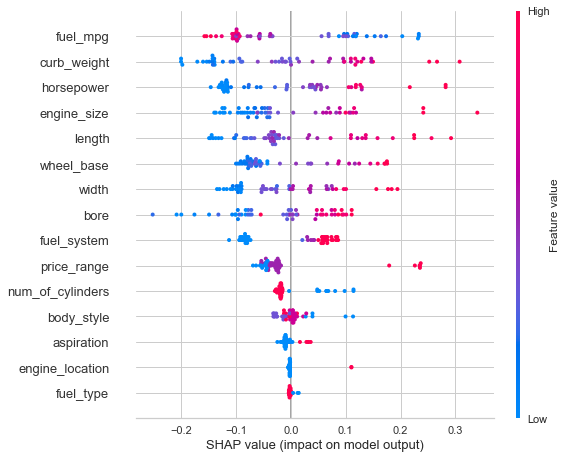

In [84]:
import shap

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)